In [1]:
import pickle
import cv2
import keras
import os
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt

2023-10-07 12:13:37.403043: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-07 12:13:37.404040: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 12:13:37.425919: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 12:13:37.426309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 12:13:37.783373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `tf.keras` framework.


In [3]:
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

In [4]:
from collections import namedtuple
#
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [5]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [6]:
#Affichage des catégories et les labels associés
id_category     = { label[4]   : label.category for label in labels  }

In [7]:
def generate_img_from_mask(mask,colors_palette=['b','g','r','c','m','y','k','w']):

    '''Génréation d'une image PIL depuis un masque segmenté et catégorie avec une couleur associée à chacune des catégories

    Args:
      mask - numpy array of dimension (shape(img),len(cats))
      cats - dict {'cat1':[value1,value2,value3],'cat2':[value1,value2,value3]}

    Returns
      PIL image'''
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')

    print("mask size :",mask.shape)
    print("img_seg size :",img_seg.shape)

    for cat in id_category.keys():
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]


    return img_seg

def affichage_result_mask(_img,_model):

    img_test_array  = cv2.imread(_img)

    # resized = cv2.resize(img_test_array,(256,128))
    resized = cv2.resize(img_test_array,(6*48,3*48))
    display(plt.imshow(resized ))

    resized = np.expand_dims(resized, axis = 0)

    mask_u = _model.predict(resized)

    print(id_category.keys())

    print("mask_u.shape before squeeze: ",mask_u.shape)
    a_s = np.squeeze(mask_u)
    # print("mask_u.shape after squeeze: ",a_s)

    mask_t=generate_img_from_mask(a_s)
    #print(mask_t)
    display(plt.imshow(mask_t))

    return mask_t

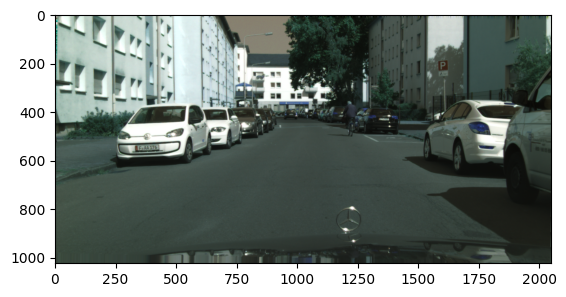

In [8]:
img_test = "P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png"
img_test_array = cv2.imread(img_test)
plt.imshow(img_test_array)

In [9]:
# loaded_model = pickle.load(open("07_last_optim.h5", 'rb'))
loaded_model = keras.models.load_model('07_last_optim.h5' ,
                                        custom_objects={
                                            "dice_loss": dice_loss,
                                            "iou_score": iou_score
                                            })

2023-10-07 12:13:38.823775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-07 12:13:38.824140: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 0s 208ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
mask_u.shape before squeeze:  (1, 144, 288, 8)
mask size : (144, 288, 8)
img_seg size : (144, 288, 3)


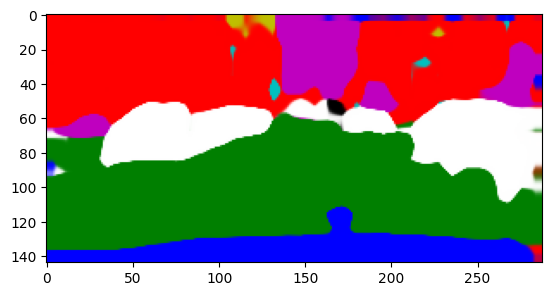

In [10]:
mask_t=affichage_result_mask(img_test, loaded_model)

In [12]:
from PIL import Image

In [21]:
img = Image.fromarray((mask_t * 255).astype(np.uint8))

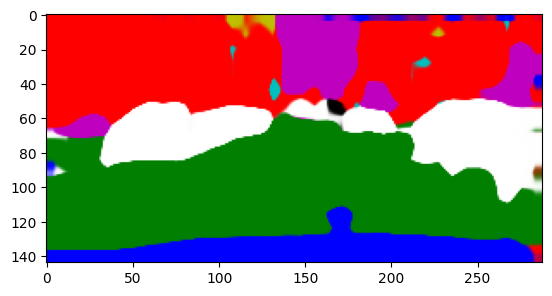

In [22]:
plt.imshow(img)